In [180]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import torch
from torch.optim import Adam, Adamax, SGD
from collections import OrderedDict
import numpy as np
from datetime import datetime
import os
import random
from sklearn.metrics import accuracy_score, classification_report
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from copy import deepcopy

In [2]:
class RandomResize(object):
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image):
        size = random.randint(self.min_size, self.max_size)
        image = transforms.functional.resize(image, size)
        return image


class RandomRotate90(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image):
        if random.random() < self.flip_prob:
            image = transforms.functional.rotate(image, 90)
        return image

    
def pad_if_smaller(img, size, fill=0):
    min_size = min(img.size)
    if min_size < size:
        ow, oh = img.size
        padh = size - oh if oh < size else 0
        padw = size - ow if ow < size else 0
        img = transforms.functional.pad(img, (0, 0, padw, padh), fill=fill)
    return img


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        image = pad_if_smaller(image, self.size)
        crop_params = transforms.RandomCrop.get_params(image, (self.size, self.size))
        image = transforms.functional.crop(image, *crop_params)
        return image

In [3]:
transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                               std=[0.2, 0.2, 0.2]),
])

train_transforms = transforms.Compose([
        RandomResize(min_size=int(0.5*256), max_size=int(1.5*256)),
        RandomCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        RandomRotate90(0.5),
        transforms.GaussianBlur((5,5), 2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                               std=[0.2, 0.2, 0.2]),
])

In [82]:
train_dataset = ImageFolder(root='./chest_xray/train/', transform=train_transforms)
val_dataset = ImageFolder(root='./chest_xray/val/', transform=transform)
test_dataset = ImageFolder(root='./chest_xray/test/', transform=transform)
test_dataset_nt = ImageFolder(root='./chest_xray/test/')

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.backbone = resnet50(*args, **kwargs)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, 2)
        
    def forward(self, *args, **kwargs):
        return self.backbone(*args, **kwargs)

In [15]:
def train(model, dataloader, optimizer, device, epoch):
    model = model.to(device)
    model = model.train()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), position=1, leave=False)
    losses = 0
    y_true = torch.Tensor([])
    y_preds = torch.Tensor([])
    for (i, (x, y)) in pbar:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        y_preds = torch.cat([y_preds, y_pred.softmax(dim=1).detach().argmax(dim=1).cpu()])
        y_true = torch.cat([y_true, y.cpu()])
#         loss = nn.functional.binary_cross_entropy_with_logits(y_pred, y.to(torch.float32).reshape(-1,1), 
#                                                               pos_weight=torch.Tensor([1/3]).to(device))
        loss = nn.functional.cross_entropy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        losses += loss.item()
        pbar.set_description(f"Loss: {losses/(i+1):.3f}")
    
    y_preds = (y_preds > 0.5).to(y_true.dtype)
    acc = accuracy_score(y_true.reshape(-1,1), y_preds)
#     acc = accuracy(y_true, y_preds)
    return losses/(i+1), acc

In [16]:
@torch.no_grad()
def validate(model, dataloader, thresh=0.5):
    model = model.to(device)
    model = model.eval()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), position=1, leave=False)
    losses = 0
    y_true = torch.Tensor([])
    y_preds = torch.Tensor([])
    for (i, (x, y)) in pbar:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = model(x)
#         y_preds = torch.cat([y_preds, y_pred.sigmoid().detach().cpu()])
        y_preds = torch.cat([y_preds, y_pred.softmax(dim=1).detach().argmax(dim=1).cpu()])
        y_true = torch.cat([y_true, y.cpu()])
        
#         loss = nn.functional.binary_cross_entropy_with_logits(y_pred, y.to(torch.float32).reshape(-1,1),
#                                                               pos_weight=torch.Tensor([1/3]).to(device))
        loss = nn.functional.cross_entropy(y_pred, y)
        losses += loss.item()
        pbar.set_description(f"Loss: {losses/(i+1):.3f}")

    y_preds = (y_preds > 0.5).to(y_true.dtype)
    acc = accuracy_score(y_true.reshape(-1,1), y_preds)
#     acc = accuracy(y_true, y_preds, threshold=thresh)
    return losses/(i+1), acc

In [17]:
@torch.no_grad()
def predict(model, dataloader):
    model = model.to(device)
    model = model.eval()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), position=1, leave=False)
    y_true = torch.Tensor([])
    y_preds = torch.Tensor([])
    for (i, (x, y)) in pbar:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = model(x)
#         y_preds = torch.cat([y_preds, y_pred.sigmoid().detach().cpu()])
        y_preds = torch.cat([y_preds, y_pred.softmax(dim=1).detach().argmax(dim=1).cpu()])
        y_true = torch.cat([y_true, y.cpu()])
        
    y_preds = (y_preds > 0.5).to(y_true.dtype)
    return y_preds, y_true

In [178]:
def plot_cam(normals, abnormals, model, version):
    i = 1
    plt.figure(figsize=(15, 10))
    for param in model.backbone.layer4[-1].parameters():
        param.requires_grad = True
    
    cam_extractor = SmoothGradCAMpp(model, target_layer=model.backbone.layer4[-1])
    for j in range(4):
        ix = normals[j].item()
        input_tensor = test_dataset[ix][0]
        out = model(input_tensor.unsqueeze(0).to(device))
        activation_map = cam_extractor(1, out)
        result = overlay_mask(transforms.functional.center_crop(
            transforms.functional.resize(
                test_dataset_nt[ix][0], (256)), (224, 224)), 
                              to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
        plt.subplot(1, 4, i)
        plt.imshow(result); plt.axis('off'); plt.tight_layout();
        i += 1
    plt.savefig(f'miss_classified_normal_{version}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(15, 10))
    i = 1
    for j in range(4):
        ix = abnormals[j].item()
        input_tensor = test_dataset[ix][0]
        out = model(input_tensor.unsqueeze(0).to(device))
        activation_map = cam_extractor(0, out)
        result = overlay_mask(transforms.functional.center_crop(
            transforms.functional.resize(
                test_dataset_nt[ix][0], (256)), (224, 224)), 
                              to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
        plt.subplot(1, 4, i)
        plt.imshow(result); plt.axis('off'); plt.tight_layout();
        i += 1
    plt.savefig(f'miss_classified_abnormal_{version}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Task 1.1

In [ ]:
now = str(datetime.now())
save_path = f'ckpt/{now}'
print('Runs:', save_path)
writer = SummaryWriter(f'runs/task_1_1/{now}')


model = Model(pretrained=False)
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

writer.add_graph(model, images)


n_epochs = 50
device = torch.device('cuda:0')
best_acc = 0

# optimizer = Adamax(model.parameters())
optimizer = SGD(params=model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

os.makedirs(save_path, exist_ok=True)
pbar = tqdm(range(n_epochs), position=0)
for epoch in pbar:
    train_loss, train_acc = train(model, train_dataloader, optimizer, device, 0)
    lr_scheduler.step()
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)

    val_loss, val_acc = validate(model, val_dataloader)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Acc/val', val_acc, epoch)
    
    state_dict = {
        'model': model.state_dict(),
        'epoch': epoch,
        'optim': optimizer.state_dict(),
        'acc': val_acc
    }
    pbar.set_description(f'Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}, Val Acc: {val_acc*100:.2f}')
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(state_dict, os.path.join(save_path, 'model_best.ckpt'))
    torch.save(state_dict, os.path.join(save_path, 'checkpoint.ckpt'))

Runs: ckpt/2024-03-16 06:41:43.571358


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

In [ ]:
model_v1 = model

In [145]:
def unfreeze_all(model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [182]:
# model_v1.backbone.layer4._forward_hooks = OrderedDict()

In [183]:
# validate(unfreeze_all(model_v1), test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

Normal acc: 0.7307692307692307
Pneumonia acc: 0.9666666666666667
Full acc: 0.8782051282051282


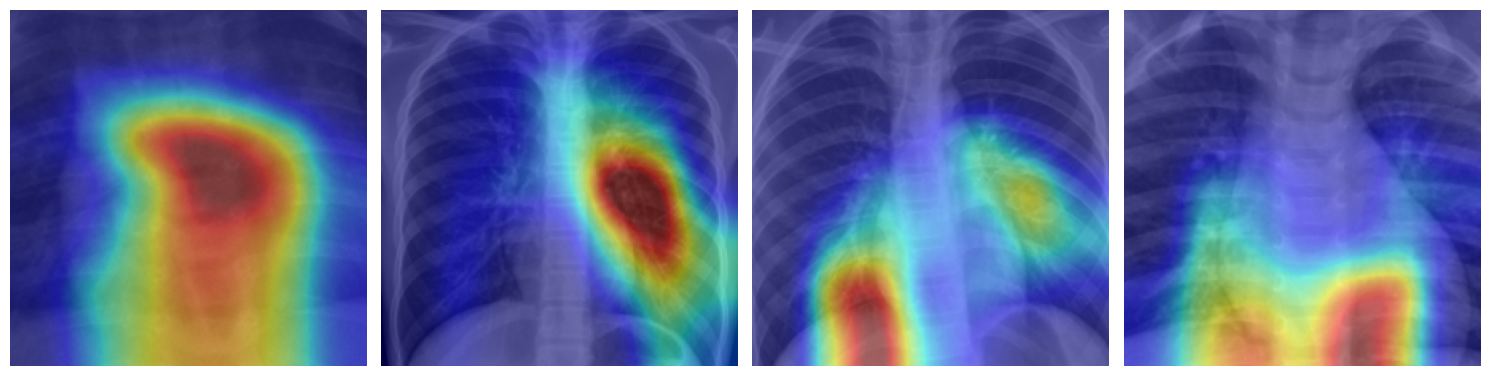

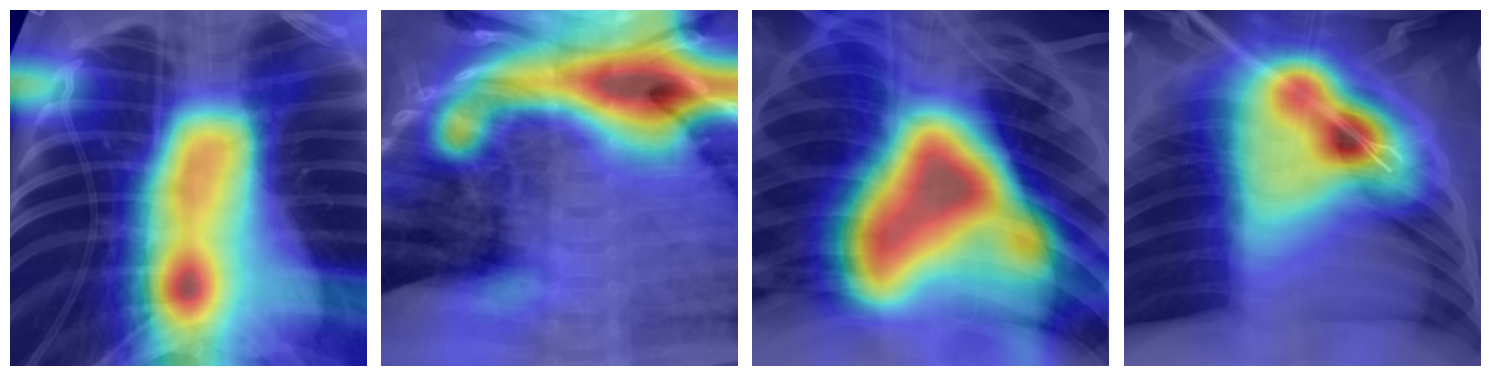

In [184]:
y_pred, y_true = predict(model_v1, test_dataloader)

y_1 = y_pred[y_true == 1]
y_0 = y_pred[y_true == 0]
print('Normal acc:', accuracy_score(y_0, torch.zeros_like(y_0)))
print('Pneumonia acc:', accuracy_score(y_1, torch.ones_like(y_1)))
print('Full acc:', accuracy_score(y_pred, y_true))

miss_classified_normals = torch.arange(len(y_pred))[(y_pred.reshape(-1) != y_true) & (y_true == 0)][:4]
miss_classified_abnormals = torch.arange(len(y_pred))[(y_pred.reshape(-1) != y_true) & (y_true == 1)][:4]

plot_cam(miss_classified_normals, miss_classified_abnormals, deepcopy(model_v1), version='v1')

## Task 1.2 v1

In [ ]:
now = str(datetime.now())
save_path = f'ckpt/{now}'
print('Runs:', save_path)
writer = SummaryWriter(f'runs/task_1_2/{now}')


model = Model(pretrained=True)

try:
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False
except:
    print("Didn't freeze weights")
    pass
                
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

writer.add_graph(model, images)

n_epochs = 50
# optimizer = Adam(model.parameters())
optimizer = SGD(params=model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)


device = torch.device('cuda:0')
best_acc = 0
os.makedirs(save_path, exist_ok=True)
pbar = tqdm(range(n_epochs), position=0)
for epoch in pbar:
    train_loss, train_acc = train(model, train_dataloader, optimizer, device, 0)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    
    lr_scheduler.step()

    val_loss, val_acc = validate(model, val_dataloader)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Acc/val', val_acc, epoch)
    
    state_dict = {
        'model': model.state_dict(),
        'epoch': epoch,
        'optim': optimizer.state_dict(),
        'acc': val_acc
    }
    pbar.set_description(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(state_dict, os.path.join(save_path, 'model_best.ckpt'))
    torch.save(state_dict, os.path.join(save_path, 'checkpoint.ckpt'))

In [37]:
# model_v2 = model

In [38]:
validate(model_v2, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

(0.7674189075129106, 0.8189102564102564)

  0%|          | 0/20 [00:00<?, ?it/s]

Normal acc: 0.8803418803418803
Pneumonia acc: 0.782051282051282
Full acc: 0.8189102564102564


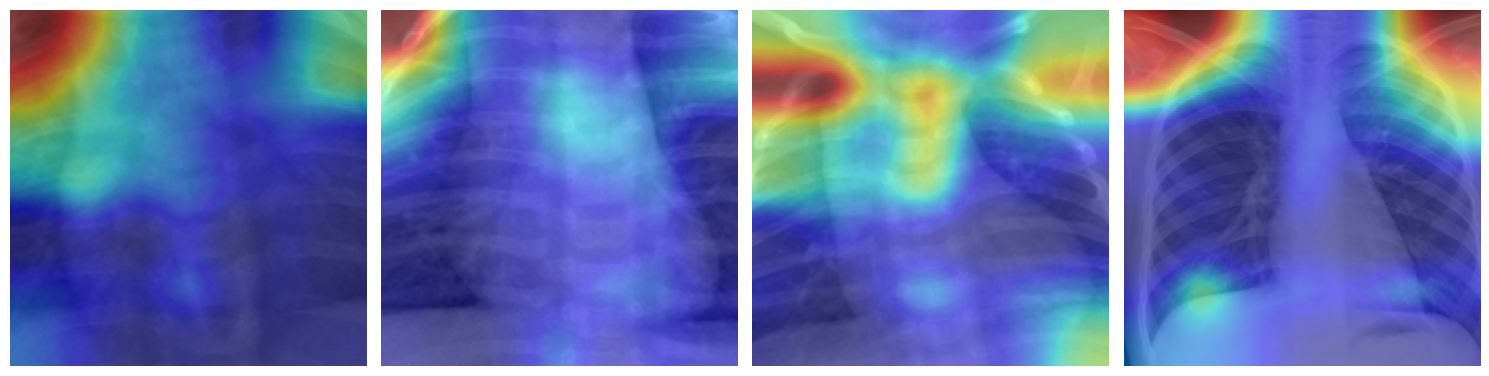

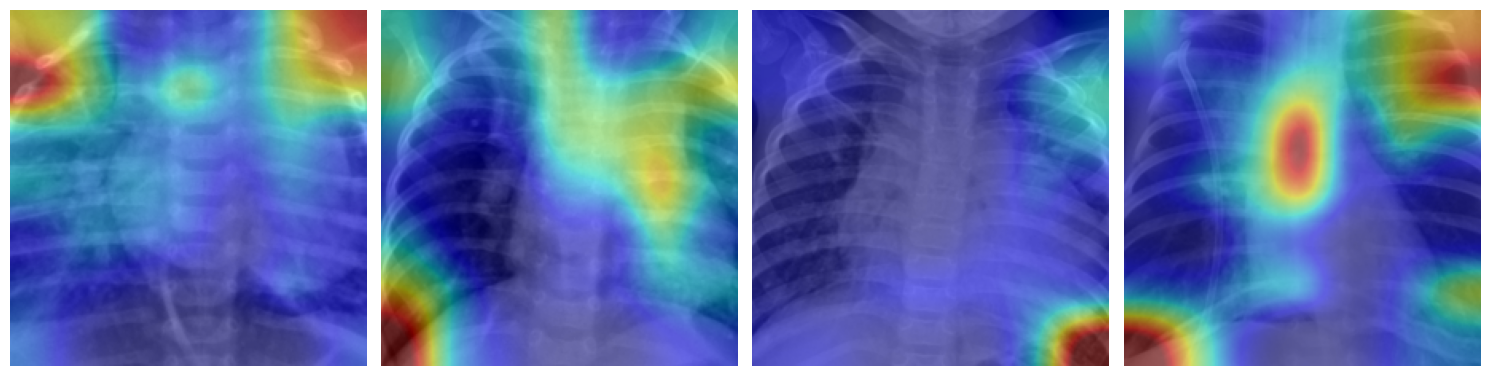

In [185]:
y_pred, y_true = predict(model_v2, test_dataloader)

y_1 = y_pred[y_true == 1]
y_0 = y_pred[y_true == 0]
print('Normal acc:', accuracy_score(y_0, torch.zeros_like(y_0)))
print('Pneumonia acc:', accuracy_score(y_1, torch.ones_like(y_1)))
print('Full acc:', accuracy_score(y_pred, y_true))

miss_classified_normals = torch.arange(len(y_pred))[(y_pred.reshape(-1) != y_true) & (y_true == 0)][:4]
miss_classified_abnormals = torch.arange(len(y_pred))[(y_pred.reshape(-1) != y_true) & (y_true == 1)][:4]

plot_cam(miss_classified_normals, miss_classified_abnormals, deepcopy(model_v2), version='v2')

## Task 1.2 v2

In [ ]:
now = str(datetime.now())
save_path = f'ckpt/{now}'
print('Runs:', save_path)
writer = SummaryWriter(f'runs/task_1_3/{now}')


model = Model(pretrained=True)
                
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

writer.add_graph(model, images)

n_epochs = 50
# optimizer = Adam(model.parameters())
optimizer = SGD(params=model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)


device = torch.device('cuda:0')
best_acc = 0
os.makedirs(save_path, exist_ok=True)
pbar = tqdm(range(n_epochs), position=0)
for epoch in pbar:
    train_loss, train_acc = train(model, train_dataloader, optimizer, device, 0)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    
    lr_scheduler.step()

    val_loss, val_acc = validate(model, val_dataloader)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Acc/val', val_acc, epoch)
    
    state_dict = {
        'model': model.state_dict(),
        'epoch': epoch,
        'optim': optimizer.state_dict(),
        'acc': val_acc
    }
    pbar.set_description(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(state_dict, os.path.join(save_path, 'model_best.ckpt'))
    torch.save(state_dict, os.path.join(save_path, 'checkpoint.ckpt'))

In [ ]:
model_v3 = model

In [41]:
validate(model_v3, test_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

(0.42236403152346613, 0.8237179487179487)

In [191]:
model_v3 = unfreeze_all(model_v3)

  0%|          | 0/20 [00:00<?, ?it/s]

Normal acc: 0.7863247863247863
Pneumonia acc: 0.8461538461538461
Full acc: 0.8237179487179487


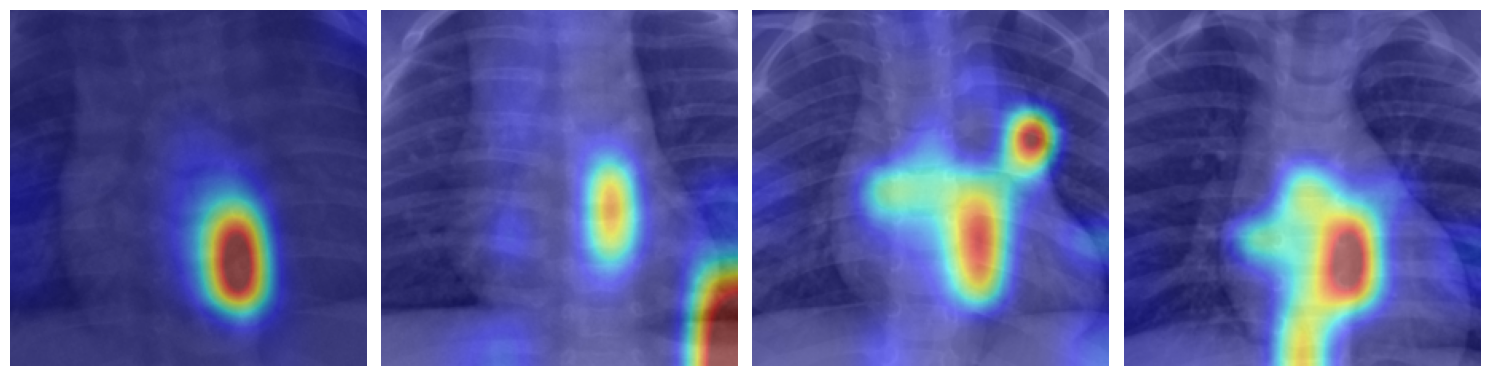

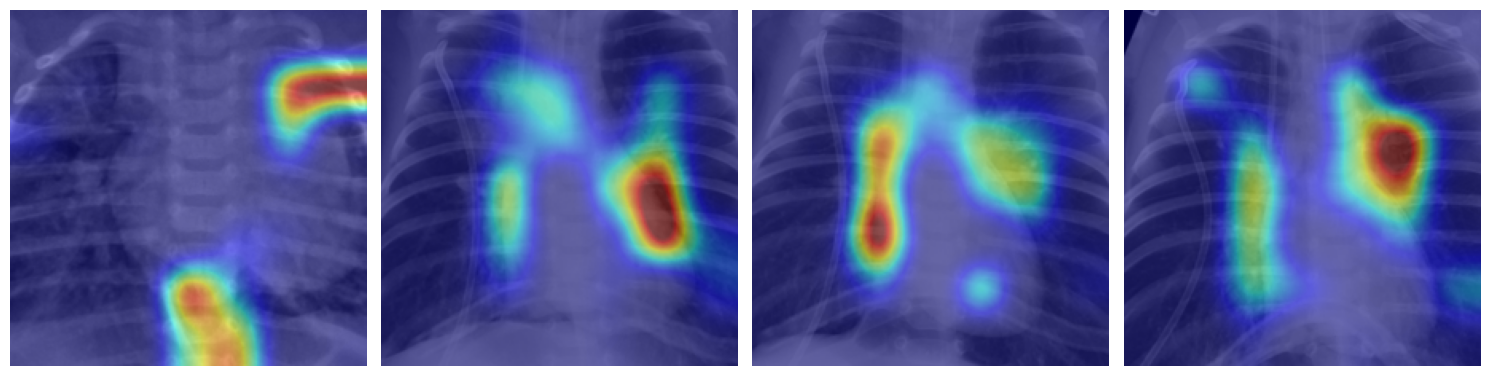

In [212]:
y_pred, y_true = predict(model_v3, test_dataloader)


y_1 = y_pred[y_true == 1]
y_0 = y_pred[y_true == 0]
print('Normal acc:', accuracy_score(y_0, torch.zeros_like(y_0)))
print('Pneumonia acc:', accuracy_score(y_1, torch.ones_like(y_1)))
print('Full acc:', accuracy_score(y_pred, y_true))

miss_classified_normals = torch.arange(len(y_pred))[(y_pred.reshape(-1) != y_true) & (y_true == 0)][:4]
miss_classified_abnormals = torch.arange(len(y_pred))[(y_pred.reshape(-1) != y_true) & (y_true == 1)][:4]

plot_cam(miss_classified_normals, miss_classified_abnormals, deepcopy(model_v3), version='v3')